In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
from datetime import datetime, date, timedelta

import io
from pysam import VariantFile

import warnings
warnings.filterwarnings('ignore')

In [3]:
context = 'paper' # talk or paper

if context == 'talk':
    sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5,'font.size': 30})
    sns.set_palette("deep")
else:
    sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.rcParams.update({'font.size': 35})
    sns.set_palette("deep")

lc = 'w' if context == 'talk' else 'k'

# For one patient

In [31]:
# CRC deep WGS patients
# MSS: 986, 809, 1014, 519, 1279
# MS status not done: 512, 1531

patient = 437 #, 1505, 330, 437
#patient = 1014

## Tumor burden

In [32]:
# tumor burden
tf_file_1 = pd.read_csv('../data/tumor_burden/tumor_burden_ichorcna_batch1.txt', header=None)
tf_file_1['patient'] = tf_file_1[0].str.split('-').str[1].str.split('_').str[0]
tf_file_1['date'] = tf_file_1[0].str.split('_').str[1]
tf_file_1['patient_date'] = tf_file_1['patient']  + '_' + tf_file_1['date'] 
tf_file_1.set_index('patient_date', inplace=True)
tf_file_1.drop(0, axis=1, inplace=True)
tf_file_1.rename(columns={1: 'tumor_burden'}, inplace=True)

tf_file_2 = pd.read_csv('../data/tumor_burden/tumor_burden_ichorcna_batch2.txt', header=None)
tf_file_2['patient'] = tf_file_2[0].str.split('_').str[0]
tf_file_2['date'] = tf_file_2[0].str.split('_').str[1]
tf_file_2['patient_date'] = tf_file_2['patient'] + '_' + tf_file_2['date'] 
tf_file_2.set_index('patient_date', inplace=True)
tf_file_2.drop(0, axis=1, inplace=True)
tf_file_2.rename(columns={1: 'tumor_burden'}, inplace=True)

tf_file_3 = pd.read_csv('../data/tumor_burden/tumor_burden_ichorcna_deepWGS.txt', header=None)
tf_file_3['patient'] = tf_file_3[0].str.split('_').str[0]
tf_file_3['date'] = tf_file_3[0].str.split('_').str[1]
tf_file_3['patient_date'] = tf_file_3['patient']  + '_' + tf_file_3['date'] 
tf_file_3.set_index('patient_date', inplace=True)
tf_file_3.drop(0, axis=1, inplace=True)
tf_file_3.rename(columns={1: 'tumor_burden'}, inplace=True)

tf_file = pd.concat([tf_file_1, tf_file_2, tf_file_3])
tf_file['patient'] = tf_file['patient'].astype(int)
tf_file['date'] = pd.to_datetime(tf_file['date'], format='%d%m%y')
tf_file.reset_index(inplace=True)
tf_file.drop('patient_date', axis=1, inplace=True)

tumorburden_dates = tf_file[tf_file['patient'] == patient]['date'].sort_values().astype(str).unique()
print(tumorburden_dates)
print(tf_file.shape)

#tf_file['patient'].unique()
print(tf_file_1.shape[0], tf_file_2.shape[0], tf_file_3.shape[0], tf_file_1.shape[0] + tf_file_2.shape[0] + tf_file_3.shape[0], tf_file.shape[0])
print(65 + 192 + 10)

print(tf_file[tf_file['patient'] == patient].shape[0])
tf_file[tf_file['patient'] == patient]

['2016-04-07' '2016-08-26' '2016-12-15' '2017-01-19' '2017-02-09']
(261, 3)
57 192 12 261 261
267
5


tumor_burden  patient       date
176        0.1776      437 2016-04-07
177        0.0000      437 2017-02-09
178        0.0000      437 2016-12-15
179        0.0000      437 2017-01-19
180        0.0000      437 2016-08-26

## Treatment

In [33]:
treatment_file = pd.read_csv('../data/treatment/patient_treatment_total_std_201109.txt', sep='\t')
treatment_file['patient'] = treatment_file['patient'].astype(int)
treatment_file['date'] = pd.to_datetime(treatment_file['date'], format='%Y-%m-%d')
treatment_file.rename(columns={'value':'treatment'}, inplace=True)
treatment_file = treatment_file[['patient', 'date', 'treatment']]
treatment_file[treatment_file['patient'] == patient]['date'].astype(str).unique()

array(['2013-10-28', '2013-11-20', '2013-12-04', '2013-12-11',
       '2013-12-18', '2013-12-26', '2014-01-02', '2014-01-09',
       '2014-01-16', '2014-01-23', '2014-01-29', '2014-02-25',
       '2014-03-04', '2014-04-22', '2014-06-12', '2014-06-30',
       '2014-07-02', '2014-07-22', '2014-07-24', '2014-08-05',
       '2014-08-25', '2014-09-09', '2015-01-21', '2015-01-22',
       '2015-02-26', '2015-03-26', '2015-04-23', '2015-05-29',
       '2015-06-25', '2015-07-23', '2015-08-13', '2015-09-03',
       '2015-09-26', '2015-10-15', '2015-11-06', '2015-11-26',
       '2015-12-23', '2016-04-25', '2016-04-27', '2016-05-06',
       '2016-05-09', '2016-05-11', '2016-05-23', '2016-05-25',
       '2016-06-02', '2016-06-06', '2016-06-08', '2016-06-20',
       '2016-07-05', '2016-07-19', '2016-08-01', '2016-08-15',
       '2016-08-30', '2016-09-13', '2016-09-26', '2016-10-10',
       '2016-10-24', '2016-11-07', '2016-11-21', '2016-12-05',
       '2016-12-06', '2016-12-19', '2017-01-09', '2017-

## Plot patient timeline

In [34]:
treatment_patient = treatment_file[treatment_file['patient'] == patient].sort_values('date')
treatment_patient['date'] = treatment_patient['date'].astype(str)
tf_patient = tf_file[tf_file['patient'] == patient].sort_values('date')
tf_patient['date'] = tf_patient['date'].astype(str)
df_patient = pd.concat([treatment_patient, tf_patient])
df_patient = df_patient.sort_values('date')

In [35]:
print([str(a) for a in tf_patient['date'].unique() if a not in df_patient['date'].unique()])
print([str(b) for b in df_patient['date'].unique() if b not in tf_patient['date'].unique()])
alldates = sorted(list(set(list(df_patient['date'].values) + list(tf_patient['date'].values))))
print(len(alldates))

[]
['2013-10-28', '2013-11-20', '2013-12-04', '2013-12-11', '2013-12-18', '2013-12-26', '2014-01-02', '2014-01-09', '2014-01-16', '2014-01-23', '2014-01-29', '2014-02-25', '2014-03-04', '2014-04-22', '2014-06-12', '2014-06-30', '2014-07-02', '2014-07-22', '2014-07-24', '2014-08-05', '2014-08-25', '2014-09-09', '2015-01-21', '2015-01-22', '2015-02-26', '2015-03-26', '2015-04-23', '2015-05-29', '2015-06-25', '2015-07-23', '2015-08-13', '2015-09-03', '2015-09-26', '2015-10-15', '2015-11-06', '2015-11-26', '2015-12-23', '2016-04-25', '2016-04-27', '2016-05-06', '2016-05-09', '2016-05-11', '2016-05-23', '2016-05-25', '2016-06-02', '2016-06-06', '2016-06-08', '2016-06-20', '2016-07-05', '2016-07-19', '2016-08-01', '2016-08-15', '2016-08-30', '2016-09-13', '2016-09-26', '2016-10-10', '2016-10-24', '2016-11-07', '2016-11-21', '2016-12-05', '2016-12-06', '2016-12-19', '2017-01-09', '2017-01-23', '2017-02-27', '2017-03-14', '2017-03-23', '2017-03-27', '2017-03-28', '2017-04-10', '2017-04-24', '2

In [36]:
daytimes = [(datetime.strptime(alldates[i], '%Y-%m-%d') - datetime.strptime(alldates[0], '%Y-%m-%d')).days
            for i in range(len(alldates))]
print(daytimes)

[0, 23, 37, 44, 51, 59, 66, 73, 80, 87, 93, 120, 127, 176, 227, 245, 247, 267, 269, 281, 301, 316, 450, 451, 486, 514, 542, 578, 605, 633, 654, 675, 698, 717, 739, 759, 786, 892, 910, 912, 921, 924, 926, 938, 940, 948, 952, 954, 966, 981, 995, 1008, 1022, 1033, 1037, 1051, 1064, 1078, 1092, 1106, 1120, 1134, 1135, 1144, 1148, 1169, 1179, 1183, 1200, 1218, 1233, 1242, 1246, 1247, 1260, 1274, 1372, 1386, 1407, 1421, 1436, 1438, 1450, 1463, 1477, 1492, 1493, 1505, 1521, 1534, 1535, 1554, 1555, 1582, 1583, 1597, 1611, 1612, 1624, 1638, 1662, 1666, 1680, 1690, 1694, 1697, 1708, 1730, 1732, 1743, 1758, 1771, 1772, 1841, 1855, 1869, 1883, 1897, 1911, 1932, 1933, 1946, 2010, 2024, 2038, 2052, 2066, 2081, 2094, 2107, 2178, 2193, 2206, 2219, 2233, 2247]


<Figure size 432x288 with 0 Axes>

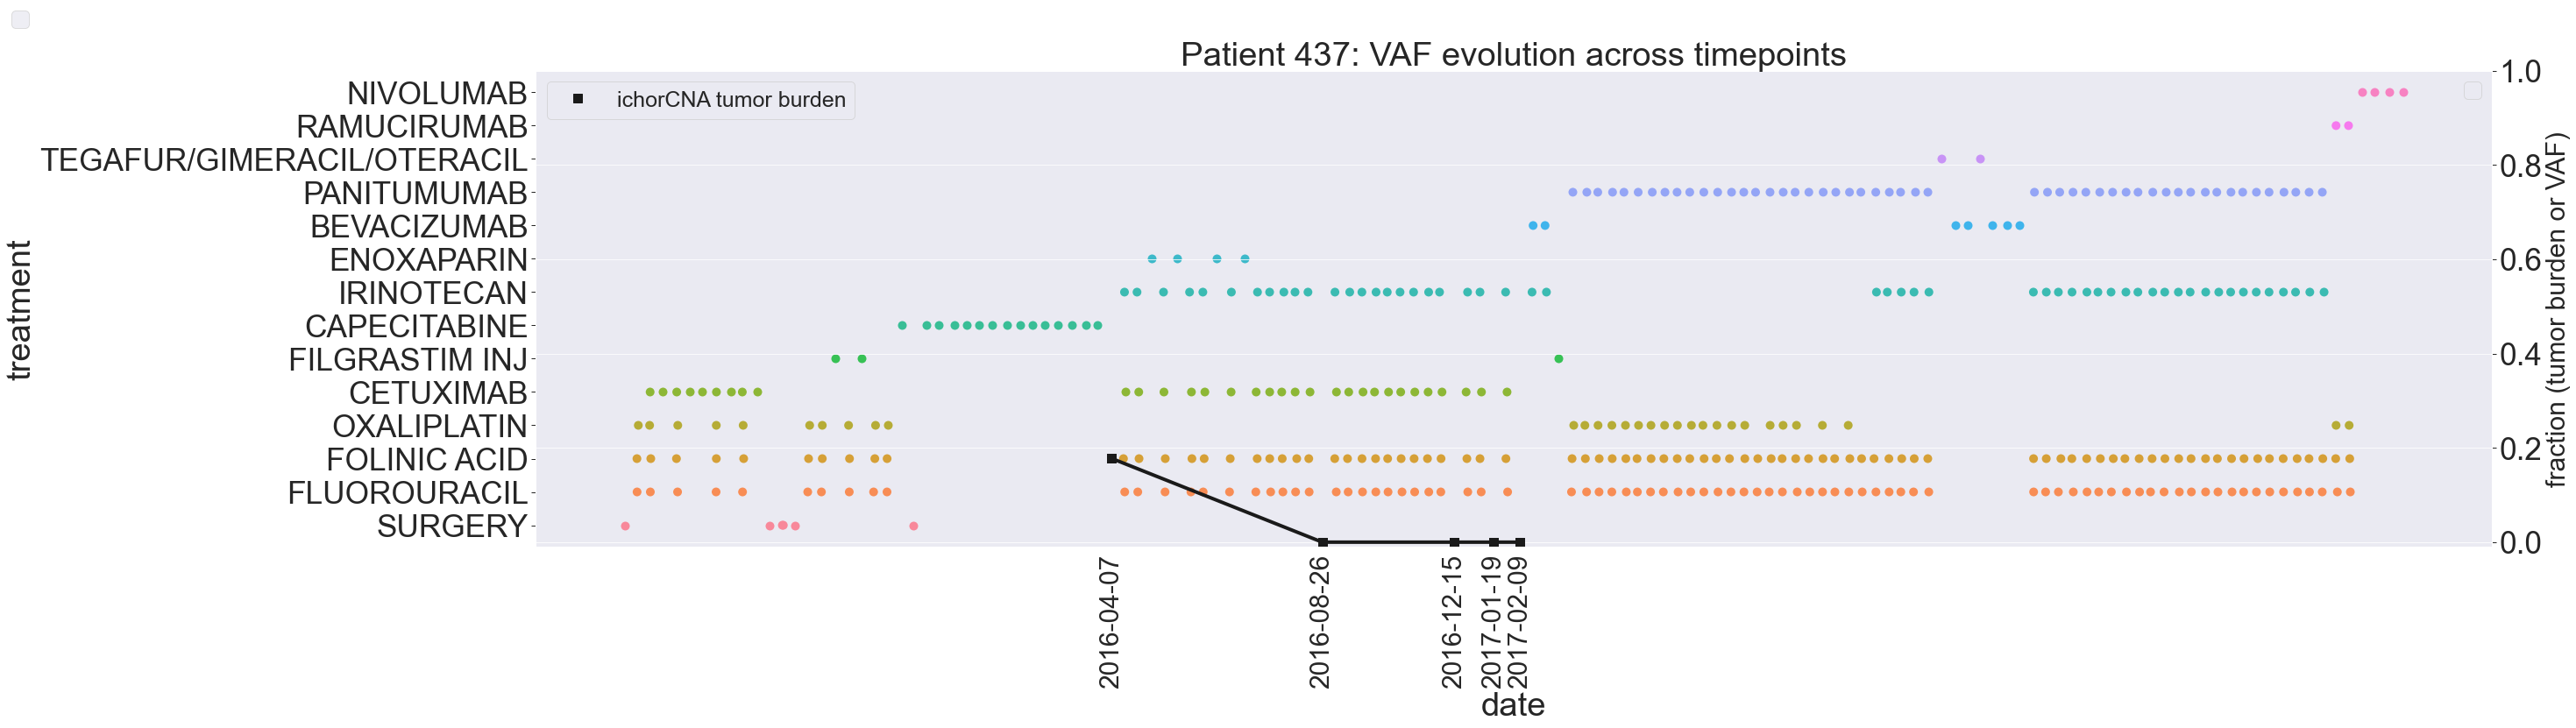

In [37]:
plt.figure()

fig, ax2 = plt.subplots(figsize=(40,10))

# make a plot with different y-axis using second axis object
sns.stripplot(y='treatment', x='date', hue='treatment', data=df_patient, s=10, ax=ax2)
ax2.grid(False)
plt.legend((), ())
        
# twin object for two different y-axis on the sample plot
ax=ax2.twinx()
ele0 = ax.plot(df_patient['date'], df_patient['tumor_burden'], lc+'.', marker='s', markersize=10, label='ichorCNA tumor burden')

ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'-', linewidth=4)
ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'.', marker='s', markersize=10)
ax.set_ylabel('fraction (tumor burden or VAF)', fontsize=30)
ax.set_ylim(-0.01, 1)

fig.legend([ele0], ['ichorCNA tumor burden'], loc='upper left')
ax.legend(loc='upper left')

labels = [ad if ad in tumorburden_dates else '' for ad in alldates]
ax2.set_xticklabels(labels, rotation=90, fontsize=30)
ax.set_xticklabels(labels, rotation=90, fontsize=30)

plt.title('Patient {}: VAF evolution across timepoints'.format(patient))

if not os.path.exists('../figures/low_tb_timepoints/oncosg_timeline_patient'+str(patient)+'.png'):
    plt.savefig('../figures/low_tb_timepoints/oncosg_timeline_patient'+str(patient)+'.png', bbox_inches='tight')
    
plt.show()

In [38]:
# check tf dates

date_lowtftimepoints = list(tf_patient[tf_patient['tumor_burden'] == 0]['date'].unique())
if date_lowtftimepoints == []:
    print('no zero ichorCNA estimate tumor burden')
    print('min tumor burden is {}'.format(min(tf_patient['tumor_burden'])))
    if min(tf_patient['tumor_burden']) < 0.1:
        date_lowtftimepoints = list(tf_patient[tf_patient['tumor_burden'] == min(tf_patient['tumor_burden'])]['date'].unique())
print(date_lowtftimepoints)
tf_patient[['date', 'tumor_burden']].T

['2016-08-26', '2016-12-15', '2017-01-19', '2017-02-09']


176         180         178         179         177
date          2016-04-07  2016-08-26  2016-12-15  2017-01-19  2017-02-09
tumor_burden      0.1776           0           0           0           0

In [39]:
date_lowtftimepoints

['2016-08-26', '2016-12-15', '2017-01-19', '2017-02-09']

## Mutation calls

In [40]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    res = pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})
    return res

In [41]:
# 226 - panel
mutation_df = pd.read_excel('../data/variant_calls/226 PANEL VARIANTS CLASSIFICSATION EXCEL/CCG_226_'+str(patient)+'_reGeno.VEP.readable_tiers.xls')
print(mutation_df.columns)

col = ['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS']
targeted_lowtf = []
for it in list(date_lowtftimepoints):
    aux1 = 'CCG_226_'+str(patient)+'.'+ it.split('-')[-1]+it.split('-')[1]+it.split('-')[0][-2:]+'.P'
    aux2 = 'CCG_226_'+str(patient)+'.'+ it.split('-')[-1]+it.split('-')[1]+it.split('-')[0][-2:]
    if sum(mutation_df.columns.str.contains(aux1)) == 1 or sum(mutation_df.columns.str.contains(aux2)) == 1:
        if sum(mutation_df.columns.str.contains(aux1)) == 1:
            idx = mutation_df.columns.str.contains(aux1).tolist().index(True)
        elif sum(mutation_df.columns.str.contains(aux2)) == 1:
            idx = mutation_df.columns.str.contains(aux2).tolist().index(True)
        col.append(mutation_df.columns[idx])
        targeted_lowtf.append(str(pd.to_datetime(mutation_df.columns[idx].split('.')[1], format='%d%m%y')).split(' ')[0])
print(col)
mutation_df = mutation_df[col]
mutation_df.insert(loc = 6,
      column = 'helper',
      value = 'hello')
mutation_lowtftimepoints_226 = (mutation_df.set_index(col[:6]+['helper'])
                               .stack()
                               .unstack(-2)
                               .ffill(axis=1)
                               .bfill(axis=1, downcast='infer')
                               .add_prefix('new_')
                               .reset_index()
                               .rename({'level_6': 'date'}, axis=1))

mutation_lowtftimepoints_226['date'] = mutation_lowtftimepoints_226['date'].str.split('.').str[1]
mutation_lowtftimepoints_226['date'] = pd.to_datetime(mutation_lowtftimepoints_226['date'], format='%d%m%y').astype(str)
foo2 = lambda x: pd.Series(float(x.split(' / ')[0])/float(x.split(' / ')[1].split(' = ')[0]))
mutation_lowtftimepoints_226['VAF'] = mutation_lowtftimepoints_226['new_hello'].apply(foo2)
mutation_lowtftimepoints_226.drop('new_hello', axis=1, inplace=True)
mutation_lowtftimepoints_226 = mutation_lowtftimepoints_226[mutation_lowtftimepoints_226['TIERS'] == 'Trusted']
print(mutation_lowtftimepoints_226.shape)
print(targeted_lowtf)
mutation_lowtftimepoints_226.head()

Index(['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'Consequence', 'Impact',
       'Biotype', 'ProteinPos', 'AminoAcidChange', 'ExistingVar',
       'PopulationVAF', '437_220414_B', 'CCG_226_437.070416.P',
       'CCG_226_437.090217.P', 'CCG_226_437.190117.P', 'TIERS'],
      dtype='object')
['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS', 'CCG_226_437.190117.P', 'CCG_226_437.090217.P']
(0, 8)
['2017-01-19', '2017-02-09']


Empty DataFrame
Columns: [#CHROM, POS, REF, ALT, GENE, TIERS, date, VAF]
Index: []

In [42]:
mutation_df.set_index(col[:6]+['helper']).stack()

#CHROM  POS        REF    ALT         GENE      TIERS     helper                      
chr5    112838115  TTAGA  T           APC       Artifact  hello   CCG_226_437.190117.P      0 / 139 = 0.000
                                                                  CCG_226_437.090217.P      0 / 197 = 0.000
chr11   118902524  G      A           CXCR5     Artifact  hello   CCG_226_437.190117.P      0 / 128 = 0.000
                                                                  CCG_226_437.090217.P      1 / 293 = 0.003
                                      BCL9L     Artifact  hello   CCG_226_437.190117.P      0 / 128 = 0.000
                                                                  CCG_226_437.090217.P      1 / 293 = 0.003
chr17   7674239    A      T           TP53      Artifact  hello   CCG_226_437.190117.P      0 / 198 = 0.000
                                                                  CCG_226_437.090217.P      4 / 318 = 0.013
chr7    152265180  C      T           KMT2C     A

In [44]:
# MCP panel
mutation_df = pd.read_csv('../data/variant_calls/final_readablefile/CCG_MCP_'+str(patient)+'_reGeno.VEP.readable.txt', sep='\t')
print(mutation_df.columns)

col = ['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS']
if 'TIERS' not in mutation_df.columns:
    mutation_df['TIERS'] = 'Trusted'

for it in list(date_lowtftimepoints):
    aux1 = 'CCG_MCP_'+str(patient)+'.'+ it.split('-')[-1]+it.split('-')[1]+it.split('-')[0][-2:]+'.P'
    if sum(mutation_df.columns.str.contains(aux1)) == 1:
        idx = mutation_df.columns.str.contains(aux1).tolist().index(True)
        print(idx)
    else:
        aux2 = 'CCG_MCP_'+str(patient)+'.'+ it.split('-')[-1]+it.split('-')[1]+it.split('-')[0][-2:]
        if sum(mutation_df.columns.str.contains(aux2)) == 1:
            idx = mutation_df.columns.str.contains(aux2).tolist().index(True)
            print(idx)
        col.append(mutation_df.columns[idx])
print(col)
mutation_df = mutation_df[col]
mutation_df.insert(loc = 6,
      column = 'helper',
      value = 'hello')
mutation_lowtftimepoints_MCP = (mutation_df.set_index(col[:6]+['helper'])
                               .stack()
                               .drop_duplicates()
                               .unstack(-2)
                               .ffill(axis=1)
                               .bfill(axis=1, downcast='infer')
                               .add_prefix('new_')
                               .reset_index()
                               .rename({'level_6': 'date'}, axis=1))

mutation_lowtftimepoints_MCP['date'] = mutation_lowtftimepoints_MCP['date'].str.split('.').str[1]
mutation_lowtftimepoints_MCP['date'] = pd.to_datetime(mutation_lowtftimepoints_MCP['date'], format='%d%m%y').astype(str)
foo2 = lambda x: pd.Series(float(x.split(' / ')[0])/float(x.split(' / ')[1].split(' = ')[0]))
mutation_lowtftimepoints_MCP['VAF'] = mutation_lowtftimepoints_MCP['new_hello'].apply(foo2)
mutation_lowtftimepoints_MCP.drop('new_hello', axis=1, inplace=True)
print(mutation_lowtftimepoints_MCP.shape)
mutation_lowtftimepoints_MCP.head()

Index(['#CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'GENE', 'Consequence', 'Impact',
       'Biotype', 'ProteinPos', 'AminoAcidChange', 'ExistingVar',
       'PopulationVAF', 'CCG_MCP_437.070416.P', 'CCG_MCP_437.090217.P',
       'CCG_MCP_437.190117.P', 'CCG_MCP_437_220414_B'],
      dtype='object')
15
14
['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS', 'CCG_MCP_437.090217.P', 'CCG_MCP_437.090217.P']
(32, 8)


helper #CHROM        POS REF ALT      GENE    TIERS        date       VAF
0        chr1   11790870   C   T  C1orf167  Trusted  2017-02-09  0.547368
1        chr1   11794419   T   G  C1orf167  Trusted  2017-02-09  0.508772
2        chr1   11796321   G   A     MTHFR  Trusted  2017-02-09  0.555556
3        chr1   47333967   G   C     CMPK1  Trusted  2017-02-09  1.000000
4        chr1  204268288   C   T   PLEKHA6  Trusted  2017-02-09  0.395161

In [46]:
#mutation_lowtftimepoints = mutation_lowtftimepoints_226
mutation_lowtftimepoints = pd.concat([mutation_lowtftimepoints_226, mutation_lowtftimepoints_MCP])
print(mutation_lowtftimepoints.shape)
print(mutation_lowtftimepoints['date'].unique())
mutation_lowtftimepoints[mutation_lowtftimepoints['TIERS'] == 'Trusted']

(32, 8)
['2017-02-09']


helper #CHROM        POS REF                  ALT       GENE    TIERS  \
0        chr1   11790870   C                    T   C1orf167  Trusted   
1        chr1   11794419   T                    G   C1orf167  Trusted   
2        chr1   11796321   G                    A      MTHFR  Trusted   
3        chr1   47333967   G                    C      CMPK1  Trusted   
4        chr1  204268288   C                    T    PLEKHA6  Trusted   
5       chr10   99784690   A                    T      ABCC2  Trusted   
6       chr11   55885487   A                    G     TRIM51  Trusted   
7       chr11   55885688   G                    A     TRIM51  Trusted   
8       chr11   67585218   A                    G      GSTP1  Trusted   
9       chr13   95206781   C                    A      ABCC4  Trusted   
10      chr17   65558473   G                    A      AXIN2  Trusted   
11      chr18    3457609   C                    T      TGIF1  Trusted   
12      chr18   36652647   C                    T      FHOD3  Trusted   
13      chr18   36744128   G                    A      FHOD3  Trusted   
14      chr19   18765499   A                    G      CRTC1  Trusted   
15       chr2  201258272   A                    G      CASP8  Trusted   
16       chr2  233760498   G                    A     UGT1A3  Trusted   
17      chr20   51790963   A                    C      SALL4  Trusted   
18      chr21   33524806   C                    T       GART  Trusted   
19      chr22   29489578   A  AAAGTCCCCTGAGAAGGCC       NEFH  Trusted   
20      chr22   29489633   A              AAGGAAG       NEFH  Trusted   
21       chr3  124737895   G                    C       UMPS  Trusted   
22       chr4   88131171   G                    T      ABCG2  Trusted   
23       chr6   36479198   G                    C     KCTD20  Trusted   
24       chr6   42659696   G                    A  RNU6-890P  Trusted   
25       chr8   63026205   G                    A        GGH  Trusted   
26       chr8   63038678   C                    T        GGH  Trusted   
27       chr8   63038753   A                    G        GGH  Trusted   
28       chr9  127802988   A                    G       FPGS  Trusted   
29       chr9  131530684   C                    G       UCK1  Trusted   
30       chr9  136853287   T                    A       AJM1  Trusted   
31       chr9  136858447   T                    G     MAMDC4  Trusted   

helper        date       VAF  
0       2017-02-09  0.547368  
1       2017-02-09  0.508772  
2       2017-02-09  0.555556  
3       2017-02-09  1.000000  
4       2017-02-09  0.395161  
5       2017-02-09  1.000000  
6       2017-02-09  1.000000  
7       2017-02-09  1.000000  
8       2017-02-09  0.530612  
9       2017-02-09  0.507692  
10      2017-02-09  0.424242  
11      2017-02-09  0.488550  
12      2017-02-09  0.462687  
13      2017-02-09  0.520492  
14      2017-02-09  0.374150  
15      2017-02-09  0.637500  
16      2017-02-09  0.631579  
17      2017-02-09  0.384106  
18      2017-02-09  1.000000  
19      2017-02-09  0.414414  
20      2017-02-09  0.243421  
21      2017-02-09  0.575949  
22      2017-02-09  0.551724  
23      2017-02-09  0.507463  
24      2017-02-09  0.512821  
25      2017-02-09  0.448980  
26      2017-02-09  0.476744  
27      2017-02-09  0.531915  
28      2017-02-09  1.000000  
29      2017-02-09  1.000000  
30      2017-02-09  0.456954  
31      2017-02-09  1.000000

In [47]:
lowtftimepoints_dict = {'date': date_lowtftimepoints,
                        'median VAF': [],
                        '# mutated genes' : [],
                        'median VAF within mutated genes': [],
                        '# mutated genes TRUSTED': [],
                        'median VAF within mutated genes TRUSTED': []
                       }

for date in date_lowtftimepoints:
    nmut = mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date) & (mutation_lowtftimepoints['VAF'] != 0)].shape[0]
    nmuttrust = mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date)  & (mutation_lowtftimepoints['VAF'] != 0)  & (mutation_lowtftimepoints['TIERS'] == 'Trusted')].shape[0]
    medianvaf = np.median(mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date)]['VAF'].values)
    medianvafn = np.median(mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date) & (mutation_lowtftimepoints['VAF'] != 0)]['VAF'].values)
    medianvafntrust = np.median(mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date) & (mutation_lowtftimepoints['VAF'] != 0) & (mutation_lowtftimepoints['TIERS'] == 'Trusted')]['VAF'].values)
    lowtftimepoints_dict['# mutated genes'].append(nmut)
    lowtftimepoints_dict['# mutated genes TRUSTED'].append(nmuttrust)
    lowtftimepoints_dict['median VAF'].append(medianvaf)
    lowtftimepoints_dict['median VAF within mutated genes'].append(medianvafn)
    lowtftimepoints_dict['median VAF within mutated genes TRUSTED'].append(medianvafntrust)
    

lowtftimepoints_pd = pd.DataFrame.from_dict(lowtftimepoints_dict)
lowtftimepoints_pd.set_index('date', inplace=True)
lowtftimepoints_pd.loc[targeted_lowtf]

median VAF  # mutated genes  median VAF within mutated genes  \
date                                                                       
2017-01-19         NaN                0                              NaN   
2017-02-09    0.525552               32                         0.525552   

            # mutated genes TRUSTED  median VAF within mutated genes TRUSTED  
date                                                                          
2017-01-19                        0                                      NaN  
2017-02-09                       32                                 0.525552

In [48]:
targeted_lowtf

['2017-01-19', '2017-02-09']

## Plot mutations timeline

In [49]:
mutation_df_MCP = pd.read_csv('../data/variant_calls/final_readablefile/CCG_MCP_'+str(patient)+'_reGeno.VEP.readable.txt', sep='\t')
print(mutation_df_MCP.columns)


col = ['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS']
if 'TIERS' not in mutation_df_MCP.columns:
    mutation_df_MCP['TIERS'] = 'Trusted'

for c in list(mutation_df_MCP.columns[6:]):
    if c.startswith('CCG_MCP_'+str(patient)):
        col.append(c)
print(col)
mutation_df_MCP = mutation_df_MCP[col]
mutation_df_MCP.insert(loc = 6,
      column = 'helper',
      value = 'hello')
mutations_acrosstime_MCP = (mutation_df_MCP.set_index(col[:6]+['helper'])
                               .stack()
                               .unstack(-2)
                               .ffill(axis=1)
                               .bfill(axis=1, downcast='infer')
                               .add_prefix('new_')
                               .reset_index()
                               .rename({'level_6': 'date'}, axis=1))
mutations_acrosstime_MCP['date'] = mutations_acrosstime_MCP['date'].str.split('.').str[1]
mutations_acrosstime_MCP['date'] = pd.to_datetime(mutations_acrosstime_MCP['date'], format='%d%m%y').astype(str)
foo2 = lambda x: pd.Series(float(x.split(' / ')[0])/float(x.split(' / ')[1].split(' = ')[0]))
mutations_acrosstime_MCP['VAF'] = mutations_acrosstime_MCP['new_hello'].apply(foo2)
mutations_acrosstime_MCP.drop('new_hello', axis=1, inplace=True)
mutations_acrosstime_MCP.rename(columns={'TIER': 'TIERS'}, inplace=True)
mutations_acrosstime_MCP = mutations_acrosstime_MCP.pivot_table(values='VAF', index='GENE', columns='date', aggfunc='first')
mutations_acrosstime_MCP = mutations_acrosstime_MCP.T
mutations_acrosstime_MCP.head()

Index(['#CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'GENE', 'Consequence', 'Impact',
       'Biotype', 'ProteinPos', 'AminoAcidChange', 'ExistingVar',
       'PopulationVAF', 'CCG_MCP_437.070416.P', 'CCG_MCP_437.090217.P',
       'CCG_MCP_437.190117.P', 'CCG_MCP_437_220414_B'],
      dtype='object')
['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS', 'CCG_MCP_437.070416.P', 'CCG_MCP_437.090217.P', 'CCG_MCP_437.190117.P', 'CCG_MCP_437_220414_B']


GENE           ABCC2     ABCC4     ABCG2      AJM1     AXIN2  C1orf167  \
date                                                                     
2016-04-07  1.000000  0.424171  0.601770  0.503125  0.355705  0.414226   
2017-01-19  1.000000  0.544643  0.350746  0.566038  0.547297  0.535714   
2017-02-09  1.000000  0.507692  0.551724  0.456954  0.424242  0.547368   
NaT         0.964286  0.515152  0.488372  0.517857  0.400000  0.655172   

GENE           CASP8  CMPK1     CRTC1     FHOD3  ...     MTHFR      NEFH  \
date                                             ...                       
2016-04-07  0.385965    1.0  0.436293  0.532338  ...  0.574713  0.382353   
2017-01-19  0.523364    1.0  0.520325  0.413408  ...  0.484848  0.445783   
2017-02-09  0.637500    1.0  0.374150  0.462687  ...  0.555556  0.414414   
NaT         0.477273    1.0  0.450000  0.500000  ...  0.590909  0.285714   

GENE         PLEKHA6  RNU6-890P     SALL4     TGIF1    TRIM51  UCK1    UGT1A3  \
date                                                                            
2016-04-07  0.333333   0.503741  0.485646  0.450262  1.000000   1.0  0.396761   
2017-01-19  0.450000   0.459459  0.430303  0.534161  1.000000   1.0  0.439252   
2017-02-09  0.395161   0.512821  0.384106  0.488550  1.000000   1.0  0.631579   
NaT         0.423077   0.475410  0.288889  0.537037  0.977778   1.0  0.448276   

GENE            UMPS  
date                  
2016-04-07  0.514360  
2017-01-19  0.452703  
2017-02-09  0.575949  
NaT         0.370968  

[4 rows x 26 columns]

In [50]:
mutation_df_226 = pd.read_excel('../data/variant_calls/226 PANEL VARIANTS CLASSIFICSATION EXCEL/CCG_226_'+str(patient)+'_reGeno.VEP.readable_tiers.xls')
print(mutation_df_226.columns)


col = ['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS']
mutation_df_226 = mutation_df_226[mutation_df_226["TIERS"] == 'Trusted']
for c in list(mutation_df_226.columns[6:]):
    if c.startswith('CCG_226_'+str(patient)):
        col.append(c)
print(col)
mutation_df_226 = mutation_df_226[col]
mutation_df_226.insert(loc = 6,
      column = 'helper',
      value = 'hello')
mutations_acrosstime_226 = (mutation_df_226.set_index(col[:6]+['helper'])
                               .stack()
                               .unstack(-2)
                               .ffill(axis=1)
                               .bfill(axis=1, downcast='infer')
                               .add_prefix('new_')
                               .reset_index()
                               .rename({'level_6': 'date'}, axis=1))
mutations_acrosstime_226['date'] = mutations_acrosstime_226['date'].str.split('.').str[1]
mutations_acrosstime_226['date'] = pd.to_datetime(mutations_acrosstime_226['date'], format='%d%m%y').astype(str)
foo2 = lambda x: pd.Series(float(x.split(' / ')[0])/float(x.split(' / ')[1].split(' = ')[0]))
mutations_acrosstime_226['VAF'] = mutations_acrosstime_226['new_hello'].apply(foo2)
mutations_acrosstime_226.drop('new_hello', axis=1, inplace=True)
mutations_acrosstime_226 = mutations_acrosstime_226.pivot_table(values='VAF', index='GENE', columns='date', aggfunc='first')
mutations_acrosstime_226 = mutations_acrosstime_226.T
mutations_acrosstime_226.head()

Index(['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'Consequence', 'Impact',
       'Biotype', 'ProteinPos', 'AminoAcidChange', 'ExistingVar',
       'PopulationVAF', '437_220414_B', 'CCG_226_437.070416.P',
       'CCG_226_437.090217.P', 'CCG_226_437.190117.P', 'TIERS'],
      dtype='object')
['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS', 'CCG_226_437.070416.P', 'CCG_226_437.090217.P', 'CCG_226_437.190117.P']


KeyError: 'new_hello'

In [112]:
#mutations_acrosstime = pd.concat([mutations_acrosstime_226, mutations_acrosstime_MCP], axis=1)
mutations_acrosstime = mutations_acrosstime_226
print(mutations_acrosstime.shape)
mutations_acrosstime.loc[targeted_lowtf]

(0, 7)


KeyError: "None of [Index(['2017-01-19', '2017-02-09'], dtype='object')] are in the [index]"

NameError: name 'mutations_acrosstime' is not defined

<Figure size 432x288 with 0 Axes>

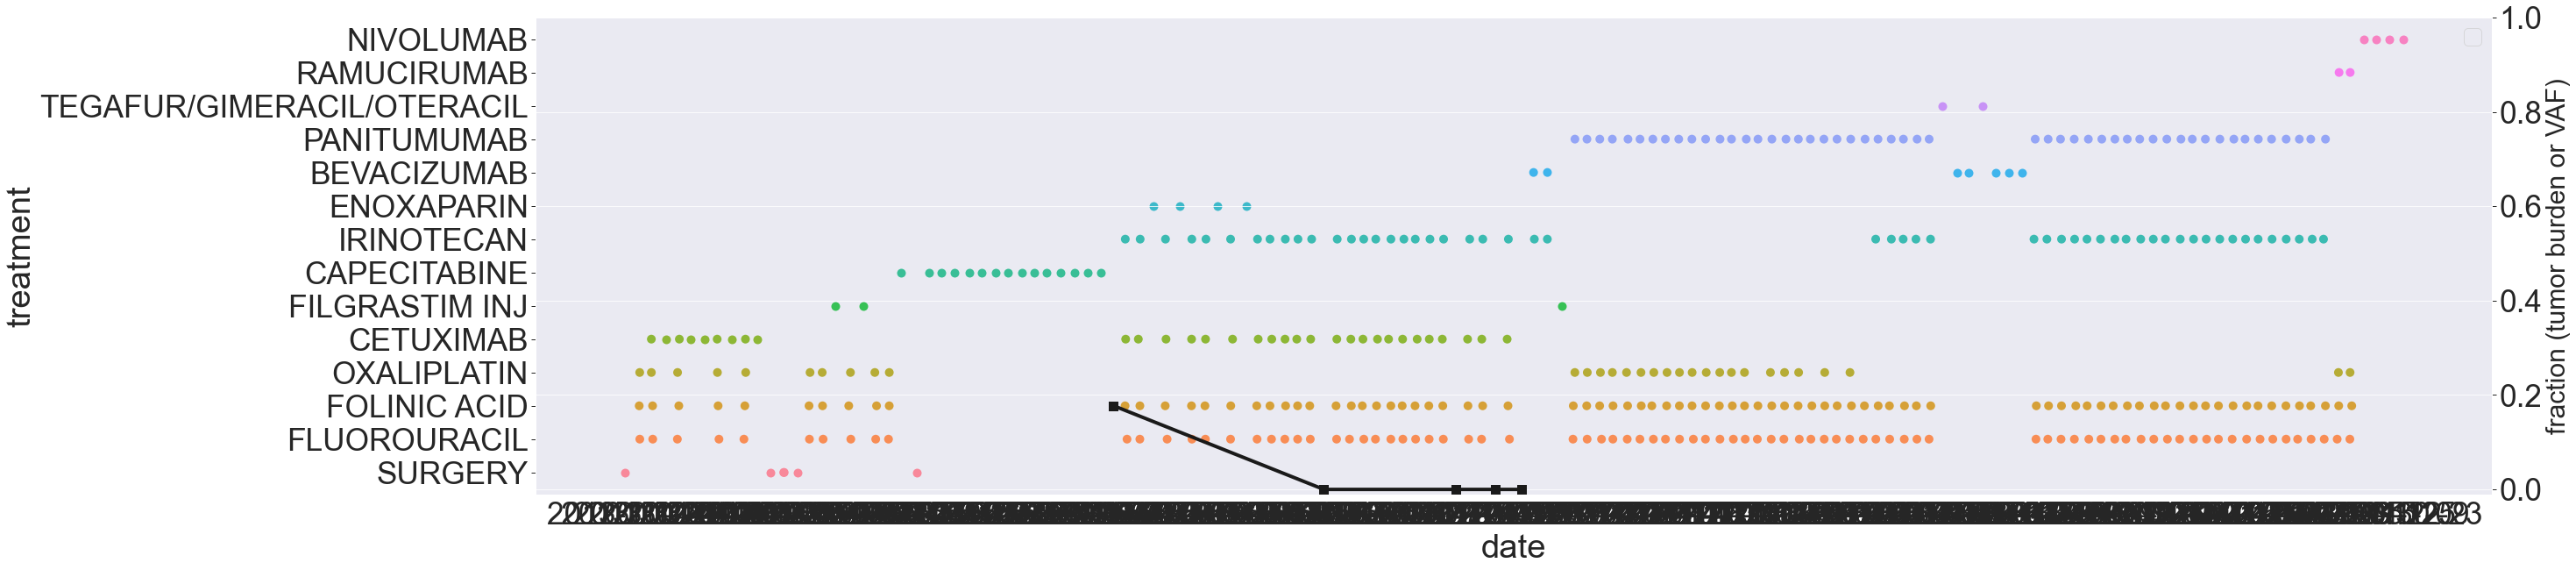

In [51]:
plt.figure()

fig, ax2 = plt.subplots(figsize=(40,10))

# make a plot with different y-axis using second axis object
sns.stripplot(y='treatment', x='date', hue='treatment', data=df_patient, s=10, ax=ax2)
labels = ax2.axes.get_xticklabels()
ax2.grid(False)
plt.legend((), ())
        
# twin object for two different y-axis on the sample plot
ax=ax2.twinx()
ele0 = ax.plot(df_patient['date'], df_patient['tumor_burden'], lc+'.', marker='s', markersize=10, label='ichorCNA tumor burden')

ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'-', linewidth=4)
ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'.', marker='s', markersize=10)
ax.set_ylabel('fraction (tumor burden or VAF)', fontsize=30)
ax.set_ylim(-0.01, 1)

xacrosstime = [i for i in mutations_acrosstime.index if i in df_patient['date'].values]

eles = [ele0]
collist = ['r', 'b', 'g', 'c', 'm', 'y', 'tab:pink', 'tab:orange', 'tab:olive', 'tab:purple', 'grey']
if mutation_df_226["TIERS"].iloc[0] == 'Trusted':
    lstype = '-' 
elif mutation_df_226["TIERS"].iloc[0] == 'LowEvidence':
    lstype = '--' 

for gi, gene in enumerate(mutations_acrosstime.columns):
    yacrosstime = [m for i,m in enumerate(mutations_acrosstime[gene].values) if mutations_acrosstime.index[i] in df_patient['date'].values]
    elei = ax.plot(xacrosstime, yacrosstime, color=collist[gi%len(collist)], ls=lstype, linewidth=2, label=gene)
    ax.plot(xacrosstime, yacrosstime, color=collist[gi%len(collist)], ls=lstype, marker='D', markersize=10)
    eles.append(elei)


fig.legend(eles, ['ichorCNA tumor burden'] + mutations_acrosstime.columns, loc='upper left')
ax.legend(loc='upper left')

labels = [ad if ad in tumorburden_dates else '' for ad in alldates]
ax2.set_xticklabels(labels, rotation=90, fontsize=30)
ax.set_xticklabels(labels, rotation=90, fontsize=30)

for dltbt in date_lowtftimepoints:
    print(dltbt)
    ax.get_xticklabels()[labels.index(dltbt)].set_color('blue') 
    ax2.get_xticklabels()[labels.index(dltbt)].set_color('blue') 
    
listdeepwgs = list(pd.to_datetime(tf_file_3[tf_file_3['patient'] == str(patient)]['date'], format='%d%m%y').astype(str).values)
for ldw in listdeepwgs:
    ax.get_xticklabels()[labels.index(ldw)].set_color('red') 
    ax2.get_xticklabels()[labels.index(ldw)].set_color('red') 

plt.title('Patient {}: VAF evolution across timepoints'.format(patient))

if not os.path.exists('../figures/low_tb_timepoints/oncosg_timeline_mutations_patient'+str(patient)+'.png'):
    plt.savefig('../figures/low_tb_timepoints/oncosg_timeline_mutations_patient'+str(patient)+'.png', bbox_inches='tight')

plt.show()

# For all patients

In [114]:
patient

437

In [ ]:
listpatients = [int(f.split('_')[2]) for f in os.listdir('../data/variant_calls/226 PANEL VARIANTS CLASSIFICSATION EXCEL/') if f.startswith('CCG')]
print(listpatients)
print(len(listpatients))

In [ ]:
for patient in listpatients:
    print(patient)
    # tumor burden

    tf_file_1 = pd.read_csv('../data/tumor_burden/tumor_burden_ichorcna_batch1.txt', header=None)
    tf_file_1['patient'] = tf_file_1[0].str.split('-').str[1].str.split('_').str[0]
    tf_file_1['date'] = tf_file_1[0].str.split('_').str[1]
    tf_file_1['patient_date'] = tf_file_1['patient']  + '_' + tf_file_1['date'] 
    tf_file_1.set_index('patient_date', inplace=True)
    tf_file_1.drop(0, axis=1, inplace=True)
    tf_file_1.rename(columns={1: 'tumor_burden'}, inplace=True)

    tf_file_2 = pd.read_csv('../data/tumor_burden/tumor_burden_ichorcna_batch2.txt', header=None)
    tf_file_2['patient'] = tf_file_2[0].str.split('_').str[0]
    tf_file_2['date'] = tf_file_2[0].str.split('_').str[1]
    tf_file_2['patient_date'] = tf_file_2['patient'] + '_' + tf_file_2['date'] 
    tf_file_2.set_index('patient_date', inplace=True)
    tf_file_2.drop(0, axis=1, inplace=True)
    tf_file_2.rename(columns={1: 'tumor_burden'}, inplace=True)

    tf_file_3 = pd.read_csv('../data/tumor_burden/tumor_burden_ichorcna_deepWGS.txt', header=None)
    tf_file_3['patient'] = tf_file_3[0].str.split('_').str[0]
    tf_file_3['date'] = tf_file_3[0].str.split('_').str[1]
    tf_file_3['patient_date'] = tf_file_3['patient']  + '_' + tf_file_3['date'] 
    tf_file_3.set_index('patient_date', inplace=True)
    tf_file_3.drop(0, axis=1, inplace=True)
    tf_file_3.rename(columns={1: 'tumor_burden'}, inplace=True)

    tf_file = pd.concat([tf_file_1, tf_file_2, tf_file_3])
    tf_file['patient'] = tf_file['patient'].astype(int)
    tf_file['date'] = pd.to_datetime(tf_file['date'], format='%d%m%y')
    tf_file.reset_index(inplace=True)
    tf_file.drop('patient_date', axis=1, inplace=True)

    tumorburden_dates = tf_file[tf_file['patient'] == patient]['date'].sort_values().astype(str).unique()
    
    treatment_file = pd.read_csv('../data/treatment/patient_treatment_total_std_201109.txt', sep='\t')
    treatment_file['patient'] = treatment_file['patient'].astype(int)
    treatment_file['date'] = pd.to_datetime(treatment_file['date'], format='%Y-%m-%d')
    treatment_file.rename(columns={'value':'treatment'}, inplace=True)
    treatment_file = treatment_file[['patient', 'date', 'treatment']]
    treatment_file[treatment_file['patient'] == patient]['date'].astype(str).unique()
    
    treatment_patient = treatment_file[treatment_file['patient'] == patient].sort_values('date')
    treatment_patient['date'] = treatment_patient['date'].astype(str)
    tf_patient = tf_file[tf_file['patient'] == patient].sort_values('date')
    tf_patient['date'] = tf_patient['date'].astype(str)
    df_patient = pd.concat([treatment_patient, tf_patient])
    df_patient = df_patient.sort_values('date')

    alldates = sorted(list(set(list(df_patient['date'].values) + list(tf_patient['date'].values))))
    
    daytimes = [(datetime.strptime(alldates[i], '%Y-%m-%d') - datetime.strptime(alldates[0], '%Y-%m-%d')).days
                for i in range(len(alldates))]
    
    date_lowtftimepoints = list(tf_patient[tf_patient['tumor_burden'] == 0]['date'].unique())
    if date_lowtftimepoints == []:
        print('no zero ichorCNA estimate tumor burden')
        print('min tumor burden is {}'.format(min(tf_patient['tumor_burden'])))
        if min(tf_patient['tumor_burden']) < 0.1:
            date_lowtftimepoints = list(tf_patient[tf_patient['tumor_burden'] == min(tf_patient['tumor_burden'])]['date'].unique())
    print(date_lowtftimepoints)
    tf_patient[['date', 'tumor_burden']].T

    plt.figure()

    fig, ax2 = plt.subplots(figsize=(40,10))

    # make a plot with different y-axis using second axis object
    sns.stripplot(y='treatment', x='date', hue='treatment', data=df_patient, s=10, ax=ax2)
    ax2.grid(False)
    plt.legend((), ())

    # twin object for two different y-axis on the sample plot
    ax=ax2.twinx()
    ele0 = ax.plot(df_patient['date'], df_patient['tumor_burden'], lc+'.', marker='s', markersize=10, label='ichorCNA tumor burden')

    ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'-', linewidth=4)
    ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'.', marker='s', markersize=10)
    ax.set_ylabel('fraction (tumor burden or VAF)', fontsize=30)
    ax.set_ylim(-0.01, 1)

    fig.legend([ele0], ['ichorCNA tumor burden'], loc='upper left')
    ax.legend(loc='upper left')

    labels = [ad if ad in tumorburden_dates else '' for ad in alldates]
    ax2.set_xticklabels(labels, rotation=90, fontsize=30)
    ax.set_xticklabels(labels, rotation=90, fontsize=30)

    plt.title('Patient {}: VAF evolution across timepoints'.format(patient))

    if not os.path.exists('../figures/low_tb_timepoints/oncosg_timeline_patient'+str(patient)+'.png'):
        plt.savefig('../figures/low_tb_timepoints/oncosg_timeline_patient'+str(patient)+'.png', bbox_inches='tight')
        
    # 226 - panel
    mutation_df = pd.read_excel('../data/variant_calls/226 PANEL VARIANTS CLASSIFICSATION EXCEL/CCG_226_'+str(patient)+'_reGeno.VEP.readable_tiers.xls')

    col = ['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS']

    for it in list(date_lowtftimepoints):
        aux1 = 'CCG_226_'+str(patient)+'.'+ it.split('-')[-1]+it.split('-')[1]+it.split('-')[0][-2:]+'.P'
        aux2 = 'CCG_226_'+str(patient)+'.'+ it.split('-')[-1]+it.split('-')[1]+it.split('-')[0][-2:]
        if sum(mutation_df.columns.str.contains(aux1)) == 1 or sum(mutation_df.columns.str.contains(aux2)) == 1:
            if sum(mutation_df.columns.str.contains(aux1)) == 1:
                idx = mutation_df.columns.str.contains(aux1).tolist().index(True)
            elif sum(mutation_df.columns.str.contains(aux2)) == 1:
                idx = mutation_df.columns.str.contains(aux2).tolist().index(True)
            col.append(mutation_df.columns[idx])
    mutation_df = mutation_df[col]
    mutation_df.insert(loc = 6,
          column = 'helper',
          value = 'hello')
    if mutation_df.shape[1] > 7:
        mutation_lowtftimepoints_226 = (mutation_df.set_index(col[:6]+['helper'])
                                       .stack()
                                       .unstack(-2)
                                       .ffill(axis=1)
                                       .bfill(axis=1, downcast='infer')
                                       .add_prefix('new_')
                                       .reset_index()
                                       .rename({'level_6': 'date'}, axis=1))

        mutation_lowtftimepoints_226['date'] = mutation_lowtftimepoints_226['date'].str.split('.').str[1]
        mutation_lowtftimepoints_226['date'] = pd.to_datetime(mutation_lowtftimepoints_226['date'], format='%d%m%y').astype(str)
        foo2 = lambda x: pd.Series(float(x.split(' / ')[0])/float(x.split(' / ')[1].split(' = ')[0]))
        mutation_lowtftimepoints_226['VAF'] = mutation_lowtftimepoints_226['new_hello'].apply(foo2)
        mutation_lowtftimepoints_226.drop('new_hello', axis=1, inplace=True)
        #mutation_lowtftimepoints_226 = mutation_lowtftimepoints_226[mutation_lowtftimepoints_226['TIERS'] == 'Trusted']

        mutation_lowtftimepoints = mutation_lowtftimepoints_226

        lowtftimepoints_dict = {'date': date_lowtftimepoints,
                            'median VAF': [],
                            '# mutated genes' : [],
                            'median VAF within mutated genes': [],
                            '# mutated genes TRUSTED': [],
                            'median VAF within mutated genes TRUSTED': []
                           }

        for date in date_lowtftimepoints:
            nmut = mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date) & (mutation_lowtftimepoints['VAF'] != 0)].shape[0]
            nmuttrust = mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date)  & (mutation_lowtftimepoints['VAF'] != 0)  & (mutation_lowtftimepoints['TIERS'] == 'Trusted')].shape[0]
            medianvaf = np.median(mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date)]['VAF'].values)
            medianvafn = np.median(mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date) & (mutation_lowtftimepoints['VAF'] != 0)]['VAF'].values)
            medianvafntrust = np.median(mutation_lowtftimepoints[(mutation_lowtftimepoints['date'] == date) & (mutation_lowtftimepoints['VAF'] != 0) & (mutation_lowtftimepoints['TIERS'] == 'Trusted')]['VAF'].values)
            lowtftimepoints_dict['# mutated genes'].append(nmut)
            lowtftimepoints_dict['# mutated genes TRUSTED'].append(nmuttrust)
            lowtftimepoints_dict['median VAF'].append(medianvaf)
            lowtftimepoints_dict['median VAF within mutated genes'].append(medianvafn)
            lowtftimepoints_dict['median VAF within mutated genes TRUSTED'].append(medianvafntrust)


        lowtftimepoints_pd = pd.DataFrame.from_dict(lowtftimepoints_dict)
        lowtftimepoints_pd.set_index('date', inplace=True)

        mutation_df_226 = pd.read_excel('../data/variant_calls/226 PANEL VARIANTS CLASSIFICSATION EXCEL/CCG_226_'+str(patient)+'_reGeno.VEP.readable_tiers.xls')


        col = ['#CHROM', 'POS', 'REF', 'ALT', 'GENE', 'TIERS']
        if mutation_df_226[mutation_df_226["TIERS"] == 'Trusted'].shape[0] != 0:
            mutation_df_226 = mutation_df_226[mutation_df_226["TIERS"] == 'Trusted']
        else:
            mutation_df_226 = mutation_df_226[mutation_df_226["TIERS"] == 'LowEvidence']
        print(mutation_df_226.shape)
        if mutation_df_226.shape[0] > 0:

            for c in list(mutation_df_226.columns[6:]):
                if c.startswith('CCG_226_'+str(patient)):
                    col.append(c)
            mutation_df_226 = mutation_df_226[col]
            mutation_df_226.insert(loc = 6,
                  column = 'helper',
                  value = 'hello')
            mutations_acrosstime_226 = (mutation_df_226.set_index(col[:6]+['helper'])
                                           .stack()
                                           .unstack(-2)
                                           .ffill(axis=1)
                                           .bfill(axis=1, downcast='infer')
                                           .add_prefix('new_')
                                           .reset_index()
                                           .rename({'level_6': 'date'}, axis=1))
            mutations_acrosstime_226['date'] = mutations_acrosstime_226['date'].str.split('.').str[1]
            mutations_acrosstime_226['date'] = pd.to_datetime(mutations_acrosstime_226['date'], format='%d%m%y').astype(str)
            foo2 = lambda x: pd.Series(float(x.split(' / ')[0])/float(x.split(' / ')[1].split(' = ')[0]))
            mutations_acrosstime_226['VAF'] = mutations_acrosstime_226['new_hello'].apply(foo2)
            mutations_acrosstime_226.drop('new_hello', axis=1, inplace=True)
            mutations_acrosstime_226 = mutations_acrosstime_226.pivot_table(values='VAF', index='GENE', columns='date', aggfunc='first')
            mutations_acrosstime_226 = mutations_acrosstime_226.T

            mutations_acrosstime = mutations_acrosstime_226


            plt.figure()

            fig, ax2 = plt.subplots(figsize=(40,10))

            # make a plot with different y-axis using second axis object
            sns.stripplot(y='treatment', x='date', hue='treatment', data=df_patient, s=10, ax=ax2)
            labels = ax2.axes.get_xticklabels()
            ax2.grid(False)
            plt.legend((), ())

            # twin object for two different y-axis on the sample plot
            ax=ax2.twinx()
            ele0 = ax.plot(df_patient['date'], df_patient['tumor_burden'], lc+'.', marker='s', markersize=10, label='ichorCNA tumor burden')

            ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'-', linewidth=4)
            ax.plot(df_patient['date'][~df_patient['tumor_burden'].isna()], df_patient['tumor_burden'][~df_patient['tumor_burden'].isna()], lc+'.', marker='s', markersize=10)
            ax.set_ylabel('fraction (tumor burden or VAF)', fontsize=30)
            ax.set_ylim(-0.01, 1)

            xacrosstime = [i for i in mutations_acrosstime.index if i in df_patient['date'].values]

            eles = [ele0]
            collist = ['r', 'b', 'g', 'c', 'm', 'y', 'tab:pink', 'tab:orange', 'tab:olive', 'tab:purple', 'grey']
            if mutation_df_226["TIERS"].iloc[0] == 'Trusted':
                lstype = '-' 
            elif mutation_df_226["TIERS"].iloc[0] == 'LowEvidence':
                lstype = '--' 

            for gi, gene in enumerate(mutations_acrosstime.columns):
                yacrosstime = [m for i,m in enumerate(mutations_acrosstime[gene].values) if mutations_acrosstime.index[i] in df_patient['date'].values]
                elei = ax.plot(xacrosstime, yacrosstime, color=collist[gi%len(collist)], ls=lstype, linewidth=2, label=gene)
                ax.plot(xacrosstime, yacrosstime, color=collist[gi%len(collist)], ls=lstype, marker='D', markersize=10)
                eles.append(elei)

            fig.legend(eles, ['ichorCNA tumor burden'] + mutations_acrosstime.columns, loc='upper left')
            ax.legend(loc='upper left')

            labels = [ad if ad in tumorburden_dates else '' for ad in alldates]
            ax2.set_xticklabels(labels, rotation=90, fontsize=30)
            ax.set_xticklabels(labels, rotation=90, fontsize=30)

            for dltbt in date_lowtftimepoints:
                ax.get_xticklabels()[labels.index(dltbt)].set_color('blue') 
                ax2.get_xticklabels()[labels.index(dltbt)].set_color('blue') 

            listdeepwgs = list(pd.to_datetime(tf_file_3[tf_file_3['patient'] == str(patient)]['date'], format='%d%m%y').astype(str).values)
            for ldw in listdeepwgs:
                ax.get_xticklabels()[labels.index(ldw)].set_color('red') 
                ax2.get_xticklabels()[labels.index(ldw)].set_color('red') 

            plt.title('Patient {}: VAF evolution across timepoints'.format(patient))

            #if not os.path.exists('../figures/low_tb_timepoints/oncosg_timeline_mutations_patient'+str(patient)+'.png'):
            plt.savefig('../figures/low_tb_timepoints/oncosg_timeline_mutations_patient'+str(patient)+'.png', bbox_inches='tight')